In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt

In [2]:
def marginal_coverage(prediction_sets, y_test):
    correct = 0
    # iterate over each row in prediction_sets and y_test
    for pred_row, actual_label in zip(prediction_sets, y_test):
        # find indices where True value is present
        pred_indices = [i for i, x in enumerate(pred_row) if x]
        # check if actual_label index is in pred_indices
        if actual_label in pred_indices:
            correct += 1
    # compute accuracy
    accuracy = correct / len(y_test)
    return accuracy

def coverage_per_label(prediction_sets, y_test, le):
    # Initialize dictionaries to store the counts of correct predictions and occurrences for each label
    correct_counts = {label: 0 for label in le.classes_}
    counts_per_label = {label: 0 for label in le.classes_}

    # Iterate over each row in prediction_sets and y_test
    for pred_row, actual_label in zip(prediction_sets, y_test):
        # Convert actual label index to label
        actual_label_name = le.classes_[actual_label]
        # Find indices where True value is present
        pred_indices = [i for i, x in enumerate(pred_row) if x]
        # Check if actual_label index is in pred_indices
        if actual_label in pred_indices:
            correct_counts[actual_label_name] += 1
        counts_per_label[actual_label_name] += 1

    # Compute coverage for each label
    coverage = coverage = {label: round(correct_counts[label] / counts_per_label[label], 2) 
                           for label in le.classes_}


    return coverage


def mean_prediction_set_sizes(prediction_sets, y_test):
    # Initialize a dictionary to store the counts of True predictions for each label
    true_counts = {label: 0 for label in le.classes_}
    counts_per_label = {label: 0 for label in le.classes_}

    # Iterate over each row in prediction_sets and y_test
    for pred_row, actual_label in zip(prediction_sets, y_test):
        # Convert actual label index to label
        actual_label = le.classes_[actual_label]
        # Find indices where True value is present
        pred_indices = [i for i, x in enumerate(pred_row) if x]
        # Check if actual label index is in pred_indices
        if pred_indices:
            true_counts[actual_label] += len(pred_indices)
            counts_per_label[actual_label] += 1

    # Compute the mean number of trues for each label
    mean_trues = {label: round((true_counts[label] / counts_per_label[label]), 1) 
                  if counts_per_label[label] > 0 else 0 for label in le.classes_}


    return mean_trues

def count_set_sizes(prediction_sets):
    # Initialize a dictionary to store the counts for each set size
    set_size_counts = {}

    # Iterate over each row in prediction_sets
    for pred_row in prediction_sets:
        # Calculate set size as the count of True values in the row
        set_size = sum(pred_row)

        # If the set size is not yet in the dictionary, add it with a count of 1
        # Otherwise, increment the count for this set size
        if set_size in set_size_counts:
            set_size_counts[set_size] += 1
        else:
            set_size_counts[set_size] = 1

    return set_size_counts

def generate_prediction_sets(X_calib, y_calib, model, confidence_level):
    # Size of calibration data
    n = len(X_calib)

    # Get the probability predictions
    predictions = model.predict_proba(X_calib)

    # We only need the probability for the true class
    prob_true_class = predictions[np.arange(n), y_calib]

    # Turn into uncertainty score (larger means more uncertain)
    scores = 1 - prob_true_class

    # Setting the alpha so that we get Confidence Level % prediction sets
    alpha = 1 - confidence_level

    # Define quantile
    q_level = np.ceil((n+1)*(1-alpha))/n  # Sample size correction

    qhat = np.quantile(scores, q_level, method='higher')  # Get the "probabilities" from the model

    return qhat

def marginal_coverage_for_confidence_levels(X_calib, y_calib, X_test, y_test, model, confidence_levels, le):
    marginal_coverage_dict = {}

    for level in confidence_levels:
        qhat = generate_prediction_sets(X_calib, y_calib, model, level)
        prediction_sets = (1 - model.predict_proba(X_test) <= qhat)
        coverage = coverage_per_label(prediction_sets, y_test, le)
        marginal_coverage = round(sum(coverage.values()) / len(coverage), 2)  # Compute the average coverage
        marginal_coverage_dict[level] = marginal_coverage

    return marginal_coverage_dict


In [3]:
CONFIDENCE_LEVEL = 0.90

In [4]:
beans = pd.read_csv("Dry_Bean_Dataset.csv",header=0)
beans

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610291.00,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638018.00,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.11,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645884.00,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620134.00,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13606,42097,759696.00,288.721612,185.944705,1.552728,0.765002,42508,231.515799,0.714574,0.990331,0.916603,0.801865,0.006858,0.001749,0.642988,0.998385,DERMASON
13607,42101,757499.00,281.576392,190.713136,1.476439,0.735702,42494,231.526798,0.799943,0.990752,0.922015,0.822252,0.006688,0.001886,0.676099,0.998219,DERMASON
13608,42139,759321.00,281.539928,191.187979,1.472582,0.734065,42569,231.631261,0.729932,0.989899,0.918424,0.822730,0.006681,0.001888,0.676884,0.996767,DERMASON
13609,42147,763779.00,283.382636,190.275731,1.489326,0.741055,42667,231.653248,0.705389,0.987813,0.907906,0.817457,0.006724,0.001852,0.668237,0.995222,DERMASON


In [5]:
# Labels are characters but should be integers for sklearn
le = LabelEncoder()
beans["Class"] = le.fit_transform(beans["Class"])
# Split data into classification target and features
y = beans["Class"]
X = beans.drop("Class", axis = 1)
# Split of training data
X_train, X_rest1, y_train, y_rest1 = train_test_split(
X, y, train_size=10000, random_state=2
)
# From the remaining data, split of test data
X_test, X_rest2, y_test, y_rest2 = train_test_split(
X_rest1, y_rest1, train_size=1000, random_state=42
)
# Split remaining into calibration and "new" data
X_calib, X_new, y_calib, y_new = train_test_split(
X_rest2, y_rest2, train_size=1000, random_state=42
)

In [6]:
# Fitting the Crap Model

# Fit the model
model = GaussianNB().fit(X_train, y_train)
model

GaussianNB()

In [7]:
from sklearn.metrics import confusion_matrix
# Check accuracy
y_pred = model.predict(X_test)
print("Accuracy:", (y_pred == y_test).mean())
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

Accuracy: 0.726


,BARBUNYA,BOMBAY,CALI,DERMASON,HOROZ,SEKER,SIRA
BARBUNYA,44,0,48,0,5,0,6
BOMBAY,0,33,0,0,0,0,0
CALI,23,0,78,0,3,0,0
DERMASON,0,0,0,217,0,37,10
HOROZ,0,0,5,3,97,0,28
SEKER,2,0,0,27,1,118,30
SIRA,0,0,0,9,10,27,139


# 1. Naive Approach 

In [8]:
# Get the "probabilities" from the model
predictions = model.predict_proba(X_calib)
# Get for each instance the highest probability
high_prob_predictions = np.amax(predictions, axis=1)
# Select the predictions where probability over Confidence Level %
high_p_beans = np.where(high_prob_predictions >= CONFIDENCE_LEVEL)
# Let's count how often we hit the right label
its_a_match = (model.predict(X_calib) == y_calib)
coverage = np.mean(its_a_match.values[high_p_beans])
print(f"Empirical Coverage: {round(coverage*100, 3):0.2f}%")

Empirical Coverage: 88.65%


# 2. Make it Conformal, please! 

In [9]:
# Size of calibration data
n = len(X_calib)
# Get the probability predictions
predictions = model.predict_proba(X_calib)
# We only need the probability for the true class
prob_true_class = predictions[np.arange(n),y_calib]
# Turn into uncertainty score (larger means more uncertain)
scores = 1 - prob_true_class

In [10]:
# Setting the alpha so that we get Confidence Level % prediction sets
alpha = 1 - CONFIDENCE_LEVEL
# define quantile
q_level = np.ceil((n+1)*(1-alpha))/n  # Sample size correction
qhat = np.quantile(scores, q_level, method='higher')

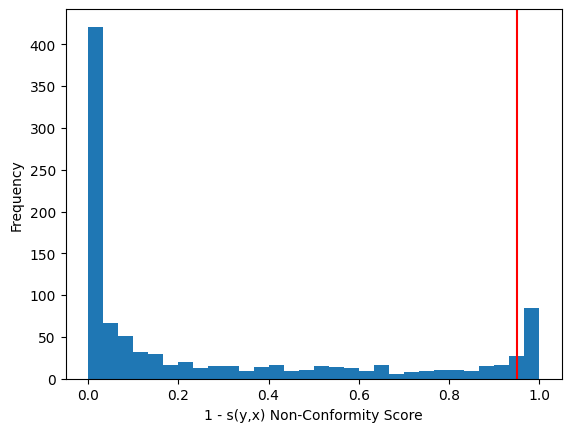

In [11]:
# Get the "probabilities" from the model
predictions = model.predict_proba(X_calib)
# Get for each instance the actual probability of ground truth
prob_for_true_class = predictions[np.arange(len(y_calib)),y_calib]
# Create a histogram
plt.hist(1 - prob_for_true_class, bins=30, range=(0, 1))
# Add a title and labels
plt.xlabel("1 - s(y,x) Non-Conformity Score")
plt.ylabel("Frequency")
plt.axvline(qhat,color="red")
plt.show()

In [12]:
prediction_sets = (1 - model.predict_proba(X_new) <= qhat)
prediction_sets

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ...,  True, False, False],
       [False, False, False, ...,  True, False, False]])

In [20]:
for i in range(25):
    print(le.classes_[prediction_sets[i]])

['DERMASON']
['DERMASON']
['DERMASON']
['DERMASON']
['DERMASON']
['DERMASON']
['HOROZ']
['BARBUNYA' 'HOROZ']
['SEKER']
['SIRA']
['HOROZ' 'SIRA']
['SEKER' 'SIRA']
['HOROZ' 'SIRA']
['BARBUNYA' 'CALI']
['HOROZ' 'SIRA']
['DERMASON']
['HOROZ']
['SIRA']
['SEKER' 'SIRA']
['SEKER' 'SIRA']
['BOMBAY']
['BARBUNYA' 'CALI']
['BARBUNYA' 'CALI']
['DERMASON']
['SEKER' 'SIRA']


## 2.1 Marginal Coverage vs. Per Class Coverage

In [14]:
marginal_coverage = marginal_coverage(prediction_sets, y_new)
print(f"Marginal Coverage: {marginal_coverage:0.2f} for a Confidence Level of {CONFIDENCE_LEVEL}")

Marginal Coverage: 0.92 for a Confidence Level of 0.9


In [15]:
mean_set_sizes = mean_prediction_set_sizes(prediction_sets, y_new)
mean_set_sizes

{'BARBUNYA': 1.9,
 'BOMBAY': 1.0,
 'CALI': 1.7,
 'DERMASON': 1.3,
 'HOROZ': 1.5,
 'SEKER': 1.6,
 'SIRA': 1.6}

In [16]:
label_coverage = coverage_per_label(prediction_sets, y_new, le)
label_coverage

{'BARBUNYA': 0.87,
 'BOMBAY': 1.0,
 'CALI': 0.92,
 'DERMASON': 0.95,
 'HOROZ': 0.87,
 'SEKER': 0.91,
 'SIRA': 0.94}

In [17]:
set_size_counts = count_set_sizes(prediction_sets)
print('Number of predictions for each set size:', set_size_counts)

Number of predictions for each set size: {1: 825, 2: 696, 3: 90}


# Putting Everything Together

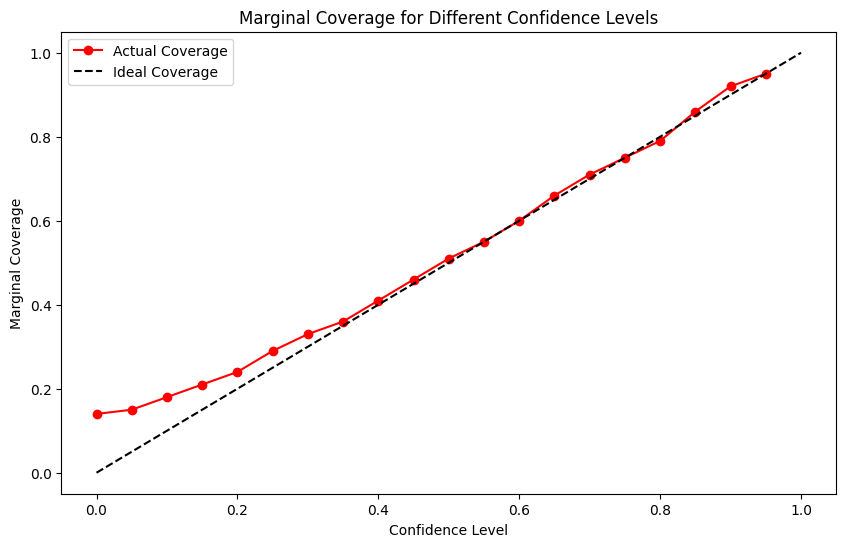

In [18]:
# Compute the marginal coverages
confidence_levels = [confidence for confidence in np.arange(0,1,0.05)]
marginal_coverage = marginal_coverage_for_confidence_levels(X_calib, y_calib, X_test, y_test, model, confidence_levels, le)

# Extract the confidence levels and marginal coverages
levels = list(marginal_coverage.keys())
coverages = list(marginal_coverage.values())

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(levels, coverages, 'ro-', label='Actual Coverage')  # make points red
plt.plot([0, 1], [0, 1], 'k--', label='Ideal Coverage')  # add dashed 45-degree line

# Add labels and title
plt.xlabel('Confidence Level')
plt.ylabel('Marginal Coverage')
plt.title('Marginal Coverage for Different Confidence Levels')

# Add legend
plt.legend()

# Show the plot
plt.show()
